
<div class="alert alert-block alert-info">

# Анализ поведения пользователей в приложении по продаже продуктов питания


<div class="alert alert-block alert-info">

**Цель исследования:**

Разобраться, как ведут себя пользователи мобильного приложения.

**План исследования:**

 - загрузка и изучение данных датасета;
 
 - предобработка исходных данных;
 
 - изучение воронки событий;
 
 - проведение  А/А/В - теста;
 
 - анализ  А/А/В - теста.
 
 - подвести итоги исследования.
 
**Описание датасета:**

 - Каждая запись в логе — это действие пользователя, или событие.

 - EventName — название события;

 - DeviceIDHash — уникальный идентификатор пользователя;

 - EventTimestamp — время события;

 - ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.
 
 
 
 



## Шаг 1. Изучение файла с данными.

In [1]:
import pandas as pd
import datetime as dt
from datetime import datetime, timedelta
from scipy import stats as st
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import math as mth
import warnings
warnings.simplefilter('ignore')

In [2]:
data = pd.read_csv('/datasets/logs_exp.csv', sep = '\t')

In [3]:
data

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246



<div class="alert alert-block alert-info">

**Вывод:**

Датасет представлен файлом с логами пользователей мобильного приложения состоящего из 4 столбов и 244 126 строк.

# **Шаг 2.** Подготовка данных.

Переименуем название в соответствии с содержимым и приведем их к "змеиному стилю".

In [4]:
data = data.rename (columns = {'EventName':'event_name', 'DeviceIDHash':'device_id', 'EventTimestamp' : 'event_time', 'ExpId':'group'})
data

,event_name,device_id,event_time,group
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


Заменим номера экспериментов на более подходящие.  

 Контрольные группы 246 и 247 переименуем в А0 и А1 соответственно,
 экспериментальной группе 248 присвоим В.

In [5]:
data = data.replace(246, 'A0').replace (247, 'A1').replace (248, 'B')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   event_name  244126 non-null  object
 1   device_id   244126 non-null  int64 
 2   event_time  244126 non-null  int64 
 3   group       244126 non-null  object
dtypes: int64(2), object(2)
memory usage: 7.5+ MB


Согласно выведенной информации столбец event_time имеет числовой тип. Изменим его на тип: datetime и добавим дополнительный столбец с датой event_date.

In [7]:
data.event_time = pd.to_datetime(data.event_time, unit='s')

In [8]:
#data['event_date'] = data.event_time.dt.date
data['event_date'] = data['event_time'].dt.date

In [9]:
data

,event_name,device_id,event_time,group,event_date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,A0,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,A0,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,B,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,B,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,B,2019-07-25
...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,A1,2019-08-07
244122,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,A0,2019-08-07
244123,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,A0,2019-08-07
244124,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,A0,2019-08-07


Произведем проверку на наличие пропусков и явных дубликатов.

In [10]:
data.isna().sum()

event_name    0
device_id     0
event_time    0
group         0
event_date    0
dtype: int64

In [11]:
data.duplicated().sum()

413

Количество дубликатов незначительно и составляет менее 1% от общего количества строк. Т.е. их удаление не отразится на результатах анализа. 

In [12]:
data = data.drop_duplicates().reset_index(drop=True)
#data

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  243713 non-null  object        
 1   device_id   243713 non-null  int64         
 2   event_time  243713 non-null  datetime64[ns]
 3   group       243713 non-null  object        
 4   event_date  243713 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 9.3+ MB


In [14]:
group_a = data.loc[(data['group'] == 'A0') | (data['group'] == 'A1'), 'device_id']
group_b = data[data['group'] == 'B']['device_id']
same_ab = data.query('device_id in @group_a and device_id in @group_b')
same_ab_count = len(same_ab.groupby(['device_id']).agg({'device_id': 'nunique'}))
print ('Количество одних и тех же пользователей в разных группах:', same_ab_count)

Количество одних и тех же пользователей в разных группах: 0


<div class="alert alert-block alert-info">

**Вывод:**
    
По итогам подготовки данных были проделана следующая работа:
 - заменены наимования групп  -  контрольные группы 246 и 247 изменены на А0 и А1, экспериментальной группе 248 изменена на В.
 - столбцам с датой был присвоен соответствующий тип;
 - добавлен дополнительная колонка с датой;
 - проведена работа по поиску пропусков и явных дубликатов  в датасете - пропуски отсутсвуют, дубликаты удалены.
 - проврено количество одних и тех же пользователей в разных группах.


# **Шаг 3.** Изучение и проверка данных.

## Количество пользователей в логе.

In [15]:
data['event_name'].count()

243713

In [16]:
data['event_name'].value_counts()
#data['event_name'].unique()
#event_count = (data.groupby(['event_name']).agg({'device_id': 'count'}))


MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64

**Вывод:**

Всего пользователей в логе - 243 713 чел. 

Мы имеем следующую воронку событий:
 - основной экран показан 119101 раз,
 - экран с предложением 46 808 раз,
 - на экран с предложенем заполнить данные для оплаты зашли - 42 668 раз,
 - успешно оплатили - 34 118 раза,
 - обучние прошли - 1 018 раза.

In [17]:
data['group'].value_counts()

B     85582
A0    80181
A1    77950
Name: group, dtype: int64

**Вывод:**
Первая контрольная группа состоит из 80 181 событий, вторая контрольная группа состоит из  77 950 событий, эксперементальная из 85 582 событий. 

In [18]:
#users_counts = (data.groupby(['group']).agg({'device_id': 'count'}))
#users_counts
#data['device_id'].isna().sum()

## Количество событий в логе.

In [19]:
event_counts_sum = data['device_id'].nunique()
event_counts_sum

7551

In [20]:

event_counts = (data.groupby(['event_name']).agg({'device_id': 'nunique'}))
event_counts

,device_id
event_name,
CartScreenAppear,3749
MainScreenAppear,7439
OffersScreenAppear,4613
PaymentScreenSuccessful,3547
Tutorial,847


## Количетво событий приходится на пользователя

In [21]:
user_mean = (data.groupby(['device_id']).agg({'event_name': 'count'}))
user_mean.mean().round(2)


event_name    32.28
dtype: float64

**Вывод:**
    
В среднем на одного пользователя приходится 32,28 событий.

## Временной интервал теста

In [22]:
print ('Дата начала теста - ', data['event_date'].min()) 

Дата начала теста -  2019-07-25


In [23]:
print ('Дата конца теста -', data['event_date'].max()) 

Дата конца теста - 2019-08-07


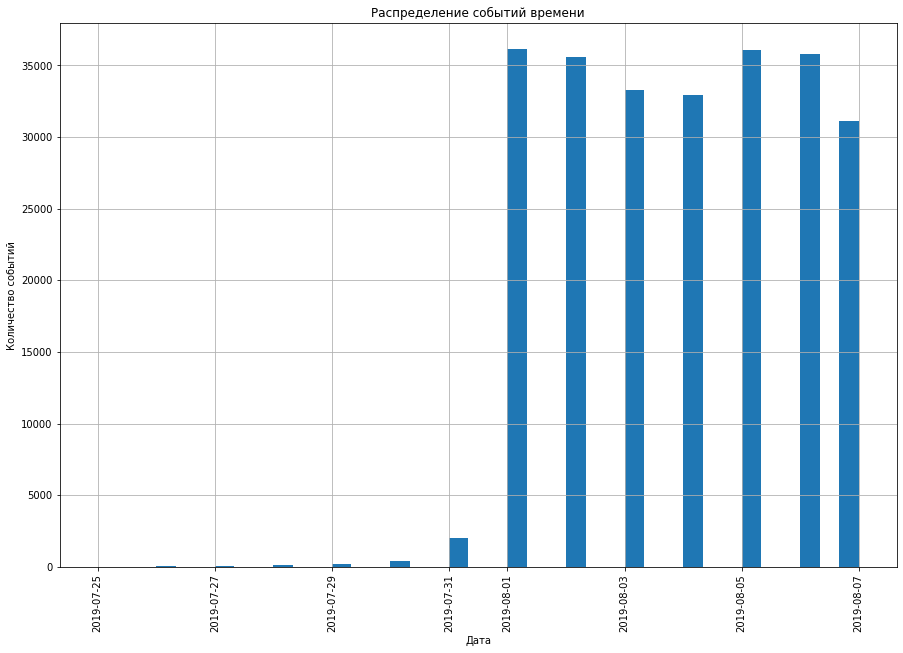

In [24]:
#plt.hist(data['event_date'])
data['event_date'].hist(figsize=(15, 10), bins = 39)
plt.title('Распределение событий времени')
plt.ylabel('Количество событий')
plt.xlabel('Дата')
plt.xticks(rotation=90)
plt.show()

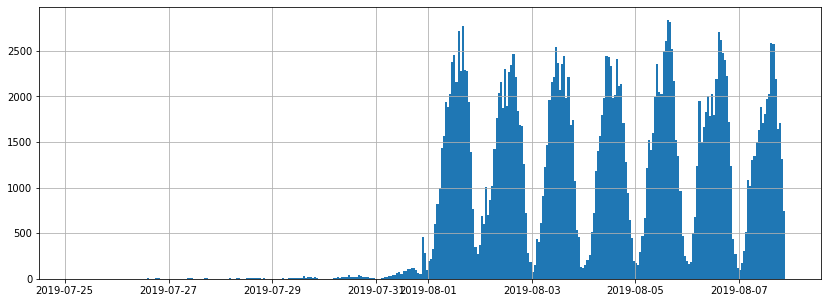

In [25]:
# код ревьюера
data['event_time'].hist(bins=14*24, figsize=(14, 5));

Из графика видно, что данные с 25.07.2019 по 31.07.2019 неполные. Их можно отбросить в следствие вероятного перекоса данных.
Начиная с 01.08.2019 данные полные и отбросьте более старые.

In [26]:
data_old = data
data = data.query('event_time >= "2019-08-01"')
data

,event_name,device_id,event_time,group,event_date
2826,Tutorial,3737462046622621720,2019-08-01 00:07:28,A0,2019-08-01
2827,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,A0,2019-08-01
2828,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,A0,2019-08-01
2829,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,A0,2019-08-01
2830,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,A1,2019-08-01
...,...,...,...,...,...
243708,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,A1,2019-08-07
243709,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,A0,2019-08-07
243710,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,A0,2019-08-07
243711,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,A0,2019-08-07


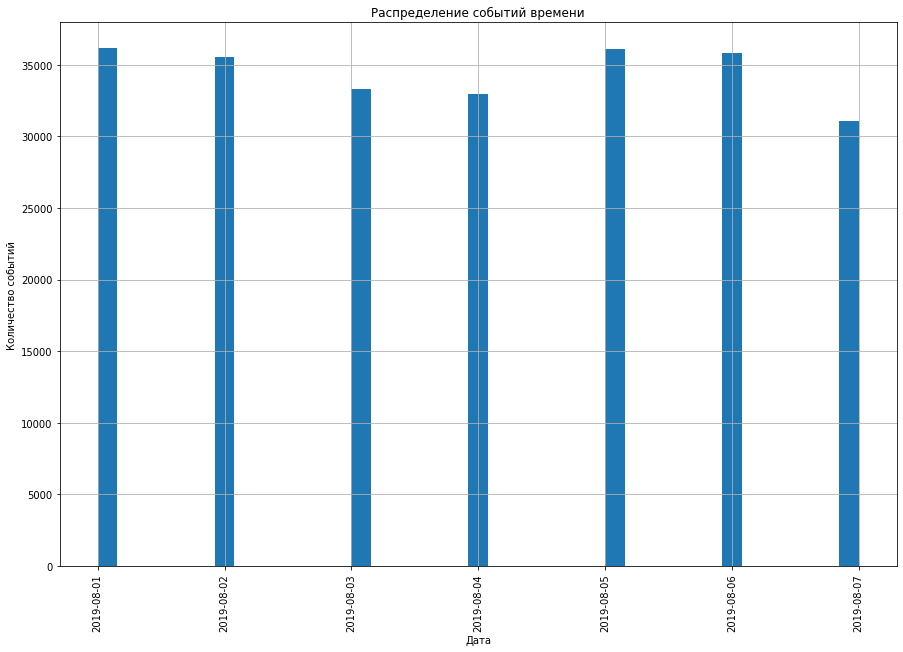

In [27]:
data['event_date'].hist(figsize=(15, 10), bins = 39)
plt.title('Распределение событий времени')
plt.ylabel('Количество событий')
plt.xlabel('Дата')
plt.xticks(rotation=90)
plt.show()

После исключения неполных данных мы располагаем полными данынми за период с 01.08.2019 по 07.08.2019.

In [28]:
data['event_name'].count()

240887

Количество событий до исключения (после удаления дубликатов) - 243 713 

По итогам иключения неполных данных, событий осталось -  240 887
 
Cобытий исключено  -  2826

In [29]:
lost_users = data_old['device_id'].nunique()-data['device_id'].nunique()
lost_users_percent = round(lost_users/data['device_id'].nunique()*100, 2)
print ('Количество потеряных пользователей составило:',lost_users, 'человек или', lost_users_percent, '%') 

lost_events = data_old['event_name'].count()-(data['event_name'].count())
lost_events_percent = round(lost_events/data['event_name'].count()*100, 2)
print ('Количество потеряных пользователей составило:',lost_events, 'событий или', lost_events_percent, '%') 


Количество потеряных пользователей составило: 17 человек или 0.23 %
Количество потеряных пользователей составило: 2826 событий или 1.17 %


## Распределение пользователей по эксперементальным группам:

In [30]:
unique_user_count = (data.groupby(['group']).agg({'device_id': 'nunique'}))
unique_user_count
#unique_user_count.sum()

,device_id
group,
A0,2484
A1,2513
B,2537


**Вывод:**

Уникальные пользователи распределены слудующим образом по группам:

A0 - 2489

A1 - 2520

B -	2542

Итого уникальных пользователей 7 751.

<div class="alert alert-block alert-info">
    
**Вывод:**
По итогам проделанной работы получена следующая информация:
Всего пользователей в логе составляет -  243 713 чел.

Имеем следующая воронка событий:

 - основной экран показан 119101 раз,
 - экран с предложением 46 808 раз,
 - на экран с предложенем заполнить данные для оплаты зашли - 42 668 раз,
 - успешно оплатили - 34 118 раза,
 - обучние прошли - 1 018 раза.   

 Первая контрольная группа состоит из 80 181 событий, вторая контрольная группа состоит из 77 950 событий, эксперементальная из 85 582 событий.
    
   Всего пользователей в логе 7551 пользователей. Они распределены следующим образом по событиям:
   
 - основной экран показан  -	3749 пользователей;
 - экран с предложением	7439 ползователей;
 - на экран с предложенем заполнить данные для оплаты зашли	4613 ползователей;
 - успешно оплатили	3547 ползователей;
 - обучние прошли  - 	847 ползователей;
    
  Среднее количество событий на пользователя составило 32.
    
    
    
    С помощью графика получена информация, что данные имеются за период  с 2019-07-25 по 2019-08-07. При этом, данные за период с 25.07.2019 по 31.07.2019 неполные. Таким образом, временной отрезок для исследования был принят начиная c 01.08.2019 по 07.08.2019 года. Количество потеряных пользователей незначительно и составило 17 человек или 0.23 % ,
количество потеряных событий составило: 2826 событий или 1.17 %.

Пользователи есть во всех трёх экспериментальных группах.

# **Шаг 4.** Изучение воронки событий.

In [31]:
#event_count = (data.groupby(['event_name']).agg({'device_id': 'count'}))
data['event_name'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

Как отмечалось ранее, мы имеем следующие события:

 - основной экран показан,
 - экран с предложением,
 - на экран с предложенем заполнить данные для оплаты зашли,
 - успешно оплатили,
 - обучние прошли.

In [32]:
event_one_count =   data.groupby('event_name').agg({'device_id': 'nunique'}).sort_values(by='device_id', ascending=False)
event_one_count['ratio'] = (event_one_count['device_id'] / data['device_id'].nunique() * 100)
event_one_count

,device_id,ratio
event_name,,
MainScreenAppear,7419,98.473586
OffersScreenAppear,4593,60.963632
CartScreenAppear,3734,49.561986
PaymentScreenSuccessful,3539,46.973719
Tutorial,840,11.149456


основной экран показан был показан 98,5% пользователей,
экран с предложением перешли 70% пользователей,,
до на экрана с предложенем успешно дошли 49,6% пользователей,,
успешно оплатили 47%  пользователей,
обучние прошли 11,4%.

In [33]:
#Уберем из событий Tutorial
event_one_count_sorted=event_one_count.query('event_name != "Tutorial" ')
event_one_count_sorted

,device_id,ratio
event_name,,
MainScreenAppear,7419,98.473586
OffersScreenAppear,4593,60.963632
CartScreenAppear,3734,49.561986
PaymentScreenSuccessful,3539,46.973719


In [34]:
event_one_count_sorted['cr'] = event_one_count_sorted['ratio']/event_one_count_sorted['ratio'].shift(1)*100
event_one_count_sorted

,device_id,ratio,cr
event_name,,,
MainScreenAppear,7419,98.473586,NaN
OffersScreenAppear,4593,60.963632,61.908613
CartScreenAppear,3734,49.561986,81.297627
PaymentScreenSuccessful,3539,46.973719,94.777718


**Вывод:**

На основании полученных таблиц видно, что самая большая часть пользователей теряется на этапе перехода на экран с предложением - порядка 40%, на этапе перехода в страницу оплаты теряется около 10%, даллее, на этапе оплаты теряется незначительная часть - 2,5%. 

Отличные показатели конверсии перехода с экрана с предложением к эрану с оплатой - 81%, а также последующей успешной оплатой -94,8%.

Всего до успешной оплаты доходят 47% пользователей приложения.

# Шаг 5. Изучение результатов эксперимента.

## Количество пользователей в каждой группе.

In [35]:
data = data.query('event_name != "Tutorial"')
groups = data.groupby('group')['device_id'].nunique()
groups['A0+A1'] = groups['A0'] + groups['A1']
groups

group
A0       2483
A1       2512
B        2535
A0+A1    4995
Name: device_id, dtype: int64

Уникальные пользователи распределены слудующим образом по группам:

- A0 - 2484
- A1 - 2513
- B - 2537
 -в группах А0 и А1 общее количество подьзователей - 4997.

Итого уникальных пользователей 7 534.

**Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверьте, находят ли статистические критерии разницу между выборками A0 и A1.**

**Критерии успешного A/A-теста:** 
- Количество пользователей в различных группах различается не более, чем на 1%;
- Для всех групп фиксируют и отправляют в системы аналитики данные об одном и том же;
- Различие ключевых метрик по группам не превышает 1% и не имеет статистической значимости;
- Попавший в одну из групп посетитель остаётся в этой группе до конца теста. Если пользователь видит разные версии исследуемой страницы в ходе одного исследования, неизвестно, какая именно повлияла на его решения. Значит, и результаты такого теста нельзя интерпретировать однозначно.

In [36]:
group_a0 = data[data['group'] == 'A0']['device_id'].nunique()
group_a1 = data[data['group'] == 'A1']['device_id'].nunique()
user_diff = round(((group_a1 - group_a0)/group_a0)*100, 1)
user_diff

1.2

Количество пользователей различается на 1,2%, что не является критичнм.

# Выберите самое популярное событие. 

 - Посчитайте число пользователей, совершивших это событие в каждой из контрольных групп. 
 - Посчитайте долю пользователей, совершивших это событие. 
 - Проверьте, будет ли отличие между группами статистически достоверным. 
 -Проделайте то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?

In [37]:
#data['event_name'].value_counts()

In [38]:
# находим самое популярное событие
popular_event =   data.groupby('event_name').agg({'group': 'count'}).sort_values(by='group', ascending=False)
popular_event

,group
event_name,
MainScreenAppear,117328
OffersScreenAppear,46333
CartScreenAppear,42303
PaymentScreenSuccessful,33918


In [39]:
events_groups = data.pivot_table(index='event_name', columns='group', values='device_id', aggfunc='count').sort_values('event_name', ascending=False)
events_groups.sort_values('A0', ascending=False)

group,A0,A1,B
event_name,,,
MainScreenAppear,37676,39090,40562
OffersScreenAppear,14767,15179,16387
CartScreenAppear,14690,12434,15179
PaymentScreenSuccessful,11852,9981,12085


**Находим самое количество уникальных пользователей в разбивке по группам.**

In [40]:
events_groups_pure = data.pivot_table(index='event_name', columns='group', values='device_id', aggfunc='nunique').sort_values(by='A0', ascending=False).reset_index()
events_groups_pure['A0+A1'] = events_groups_pure['A0'] + events_groups_pure['A1']
events_groups_pure['overall'] = events_groups_pure['A0']+events_groups_pure['A1']+events_groups_pure['B']
events_groups_pure['A0%'] = (events_groups_pure['A0'] / groups['A0'] * 100).round(2)
events_groups_pure['A1%'] = (events_groups_pure['A1'] / groups['A1'] * 100).round(2)
events_groups_pure['B%'] = (events_groups_pure['B'] / groups['B'] * 100).round(2)
events_groups_pure['A0+A1%'] = (events_groups_pure['A0+A1'] / groups['A0+A1'] * 100).round(2)
events_groups_pure.sort_values('overall', ascending=False)


group,event_name,A0,A1,B,A0+A1,overall,A0%,A1%,B%,A0+A1%
0,MainScreenAppear,2450,2476,2493,4926,7419,98.67,98.57,98.34,98.62
1,OffersScreenAppear,1542,1520,1531,3062,4593,62.10,60.51,60.39,61.30
2,CartScreenAppear,1266,1238,1230,2504,3734,50.99,49.28,48.52,50.13
3,PaymentScreenSuccessful,1200,1158,1181,2358,3539,48.33,46.10,46.59,47.21


Согласно таблице, группа А0 имеет из 2450 пользователей, но до формления заказа дошли всего 1200 пользователей, группа А1 имеет 2476 пользователей, но заказ оплатили всего лишь 1158 пользователей.

Проверем, находят ли статистические критерии разницу между выборками А0 и А1.

**Сформируем гипотезы:**

**Нулевая гипотеза:** Между долями нет значимой разницы;

**Альтернативная гипотеза:** Между долями есть значимая разница;

Порогом статистической значимости установим в размере 0.01

**Вывод:**

Самым популярным событием является MainScreenAppear. Он показан 117 328 раз, количество уникальных пользователей - 7419. 
Потери на этапе перехода OffersScreenAppear составило 37%.

Число пользователей по группам:
- A0 - 2450
- A1 - 2476
- B - 2493

In [41]:

alpha = 0.01  # критический уровень статистической значимости

success = np.array([1200, 1158])
trials = np.array([2450, 2476])

p1 = success[0]/trials[0]
p2 = success[1]/trials[1]
p_combined = (success[0] + success[1]) / (trials[0] + trials[1])

difference = p1 - p2

z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
distr = st.norm(0, 1)  
p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )

p-значение:  0.12044299485641763
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Вывод:**
Результат z-теста демонстрирует, что нет статистически значимой разницы между конверсиями пользователей в оплату заказа между выборками А0 и А1.

Можно сказать, что разбиение на группы работает корректно. Таким образом, группы А0 и А1 считаем контрольными


<div class="alert alert-block alert-info">

Для вычисления допустимой вероятности ложноположительного результата хотя бы в одном из 16 тестов необходимо использовать формулу обратной вероятности (формула Бонферрони):

P(хотя бы один ложноположительный результат) = 1 - P(ни одного ложноположительного результата)

P(ни одного ложноположительного результата) = (1 - 0.05)^16 = 0.259

Таким образом, P(хотя бы один ложноположительный результат) = 1 - 0.259 = 0.741

Допустимая вероятность ложноположительного результата хотя бы в одном из 16 тестов составляет 0.741 или 74.1%. Это значительно выше, чем допустимое значение 0.05 для одного теста. Поэтому, в таких случаях, следует использовать поправки на множественные сравнения (например, метод Холма-Бонферрони или метод Бенджамини-Хохберга).

Проверим, будет ли отличие между группами статистически достоверным для всех событий с помощью отдельной функции.

## Создадим функцию для проведения теста

def z_test(group_1, group_2):
    alpha = 0.01
    p1_event = events_groups_pure.loc[event_name, group_1]
    p2_event = events_groups_pure.loc[event_name, group_2] 
    p1_users = groups.loc[group_1] 
    p2_users = groups.loc[group_2] 

    # пропорция успехов в первой группе:
    p1 = p1_event / p1_users 
    # пропорция успехов во второй группе
    p2 = p2_event / p2_users 
    
    p_combined = (p1_event + p2_event) / (p1_users + p2_users) 
    difference = p1 - p2 
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / p1_users + 1 / p2_users)) 
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('Проверка для групп {} и {}, событие: {}, p-значение: {p_value:.2f}'.format(group_1, group_2, event_name, p_value=p_value))
  
   
    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")

In [42]:
def z_test(successes1, successes2, trials1, trials2, alpha = 0.05):
    
    # пропорция успехов в первой группе:
    p1 = successes1 / trials1 
    # пропорция успехов во второй группе
    p2 = successes2 / trials2
    
    p_combined = (successes1 + successes2) / (trials1 + trials2) 
    difference = p1 - p2 
    z_value = difference / np.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2)) 
    distr = stats.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('p-значение: ', p_value)
    print ('уровень значимости: ', alpha)
   
    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет основания считать доли разными")
    print()    

In [43]:
#groups.loc['A0']

In [44]:
#groups.loc['A1']

In [45]:
#events_groups_pure.loc[event_name, 'A0']

In [46]:
#events_groups_pure.loc[event_name, 'A1']

In [47]:
for event_name in events_groups_pure.index:
    z_test(events_groups_pure.loc[event_name, 'A0'], events_groups_pure.loc[event_name, 'A1'], groups.loc['A0'], groups.loc['A1'])
    print()

p-значение:  0.7526703436483038
уровень значимости:  0.05
Не получилось отвергнуть нулевую гипотезу, нет основания считать доли разными


p-значение:  0.24786096925282264
уровень значимости:  0.05
Не получилось отвергнуть нулевую гипотезу, нет основания считать доли разными


p-значение:  0.22867643757335676
уровень значимости:  0.05
Не получилось отвергнуть нулевую гипотезу, нет основания считать доли разными


p-значение:  0.11446627829276612
уровень значимости:  0.05
Не получилось отвергнуть нулевую гипотезу, нет основания считать доли разными




for event_name in events_groups_pure.index:
    z_test('A0', 'A1')

In [48]:
for event_name in events_groups_pure.index:
    z_test(events_groups_pure.loc[event_name, 'A0'], events_groups_pure.loc[event_name, 'B'], groups.loc['A0'], groups.loc['B'])
    print()

p-значение:  0.3387114076159288
уровень значимости:  0.05
Не получилось отвергнуть нулевую гипотезу, нет основания считать доли разными


p-значение:  0.21442476639710506
уровень значимости:  0.05
Не получилось отвергнуть нулевую гипотезу, нет основания считать доли разными


p-значение:  0.08067367598823139
уровень значимости:  0.05
Не получилось отвергнуть нулевую гипотезу, нет основания считать доли разными


p-значение:  0.21693033984516674
уровень значимости:  0.05
Не получилось отвергнуть нулевую гипотезу, нет основания считать доли разными




for event_name in events_groups_pure.index:
    z_test('A0', 'B')


In [49]:
for event_name in events_groups_pure.index:
    z_test(events_groups_pure.loc[event_name, 'A1'], events_groups_pure.loc[event_name, 'B'], groups.loc['A1'], groups.loc['B'])
    print()

p-значение:  0.5194964354051703
уровень значимости:  0.05
Не получилось отвергнуть нулевую гипотезу, нет основания считать доли разными


p-значение:  0.9333751305879443
уровень значимости:  0.05
Не получилось отвергнуть нулевую гипотезу, нет основания считать доли разными


p-значение:  0.5878284605111943
уровень значимости:  0.05
Не получилось отвергнуть нулевую гипотезу, нет основания считать доли разными


p-значение:  0.7275718682261119
уровень значимости:  0.05
Не получилось отвергнуть нулевую гипотезу, нет основания считать доли разными




for event_name in events_groups_pure.index:
    z_test('A1', 'B')

In [50]:
for event_name in events_groups_pure.index:
    z_test(events_groups_pure.loc[event_name, 'A0+A1'], events_groups_pure.loc[event_name, 'B'], groups.loc['A0+A1'], groups.loc['B'])
    print()

p-значение:  0.3486684291093256
уровень значимости:  0.05
Не получилось отвергнуть нулевую гипотезу, нет основания считать доли разными


p-значение:  0.44582745409482394
уровень значимости:  0.05
Не получилось отвергнуть нулевую гипотезу, нет основания считать доли разными


p-значение:  0.18683558686831558
уровень значимости:  0.05
Не получилось отвергнуть нулевую гипотезу, нет основания считать доли разными


p-значение:  0.6107918742187335
уровень значимости:  0.05
Не получилось отвергнуть нулевую гипотезу, нет основания считать доли разными




for event_name in events_groups_pure.index:
    z_test('A0+A1', 'B')

Вывод: По итогам проведенных тестов, получен результат, что статистически значимой разницы для всех событий воронки между контрольными и экперементальной группами нет.

# Общий вывод.

По результатам проведенных тестов, значимой разницы между долями в контрольных группах и экспериментальной не выявлено. Поэтому можно утверждать, что на поведение пользователей изменение шрифта значимого эффекта не оказало. Тестирование можно считать завершённым, результат - новый шрифт не влияет на конверсию.